# Exercises, code template, and explanation courtesy of: Rasmus Bååth and Christophe Carvenius
## Exercise 1: Bayesian Method A testing for Swedish Fish Incorporated (Method B comes later)

Swedish Fish Incorporated is the largest Swedish company delivering fish by mail order. They are now trying to get into the lucrative Danish market by selling one year Salmon subscriptions. The marketing department have done a pilot study and tried the following marketing method:

A: Sending a mail with a colorful brochure that invites people to sign up for a one year salmon subscription.

The marketing department sent out 16 mails of type A. Six Danes that received a mail signed up for one year of salmon and marketing now wants to know, how good is method A?



## Question 1 - Build a Bayesian model that answers the question: What would the rate of sign-up be if method A was used on a larger number of people?

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan 
from scipy.stats import beta
import pystan
import arviz
%load_ext jupyterstan

---
### Using a generative model

In [3]:
def single_plot_format(title='title',xlabel='xlabel',ylabel='ylabel',
                       df=pd.DataFrame(),df2=pd.DataFrame(),
                       density=True,alpha=1,color='navajowhite',color2='lavender',
                       label='',
                       label2='',
                       hatch='',
                       hatch2=''):
#     fig, ax = plt.subplots()
    plt.figure(figsize=(11,8))
#     if not df.empty():
    if not df.empty:
        ax = df.hist(alpha=alpha, density=True, color=color, label=label,hatch=hatch)
    if not df2.empty:
        ax2 = df2.hist(alpha=alpha, density=True, color=color2, label=label2,hatch=hatch2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()   
    

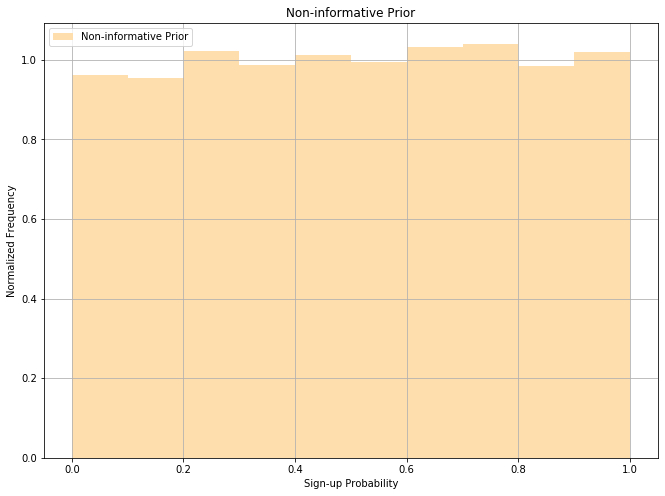

In [4]:
# Number of random draws from the prior
n_draws = 10000

# Here you sample n_draws draws from the prior into a pandas Series (to have convenient
# methods available for histograms and descriptive statistics, e.g. median)
non_inform_prior = pd.Series(np.random.uniform(0, 1, size = n_draws))

# It's always good to eyeball the prior to make sure it looks ok.
# non_inform_prior.hist(density=True)
single_plot_format(title='Non-informative Prior', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=non_inform_prior,
                   label='Non-informative Prior')

In [5]:
# Here you define the generative model.
def generative_model(prob):
    val = np.random.binomial(16, prob)
    return val
    
# It was observed that 6 out of 16 people who recieved the mail signed up for the service.
observed_data_A = 6
                    
# Here you filter off all draws that do not match the data.
def filter_w_observ(prior,observed_data):
    #list to hold the simulated data using the parameters from the prior and the generative model
    subscribers = [generative_model(p) for p in prior]
    posterior = prior[list(map(lambda x: x == observed_data, subscribers))]
    return posterior

posterior_A = filter_w_observ(non_inform_prior,observed_data_A)

---
### Using Pystan

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_813b8efe37395e7f245d628f5687c1fe NOW.


Inference for Stan model: anon_model_813b8efe37395e7f245d628f5687c1fe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate   0.39  2.9e-3   0.11   0.18   0.31   0.38   0.46   0.62   1540    1.0
lp__ -12.57    0.02   0.75 -14.75 -12.77 -12.27 -12.08 -12.03   1403    1.0

Samples were drawn using NUTS at Sun Jan 12 10:23:06 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)


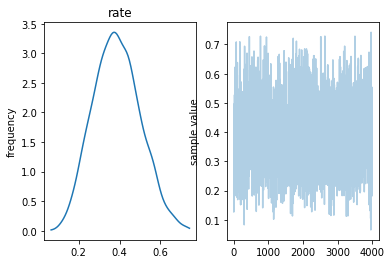

In [6]:
model_string = """
# Here we define the data we are going to pass into the model
data {
  int n; # Number of trials
  int s;  # Number of successes
}

# Here we define what 'unknowns' aka parameters we have which is the underlying sucess (rate)
parameters {
  real<lower=0, upper=1> rate;
}

# The generative model
model {
  rate ~ uniform(0, 1);
  s ~ binomial(n, rate);
}

"""

data_list_A = dict(n = 16, s = 6)

# Compiling and producing posterior samples from the model.
stan_samples_A = pystan.stan(model_code = model_string, data = data_list_A)

# Plotting and summarizing the posterior distribution
print(stan_samples_A)
print(stan_samples_A.plot())

# Export the samples to a data.frame for easier handling.
posterior_stanA = pd.DataFrame(stan_samples_A.extract())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_813b8efe37395e7f245d628f5687c1fe NOW.


Inference for Stan model: anon_model_813b8efe37395e7f245d628f5687c1fe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate   0.39  2.8e-3   0.11   0.19   0.31   0.39   0.46   0.61   1539    1.0
lp__ -12.52    0.02   0.68 -14.49 -12.67 -12.26 -12.08 -12.03   2025    1.0

Samples were drawn using NUTS at Sun Jan 12 10:24:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)


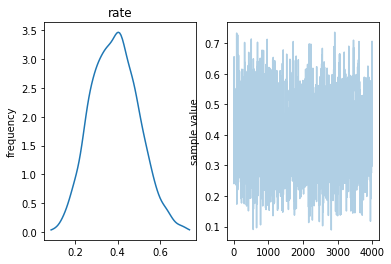

In [7]:
model_string = """
# Here we define the data we are going to pass into the model
data {
  int n; # Number of trials
  int s;  # Number of successes
}

# Here we define what 'unknowns' aka parameters we have which is the underlying sucess (rate)
parameters {
  real<lower=0, upper=1> rate;
}

# The generative model
model {
  rate ~ uniform(0, 1);
  s ~ binomial(n, rate);
}

"""

data_list_A = dict(n = 16, s = 6)

# Compiling and producing posterior samples from the model.
stan_samples_A = pystan.stan(model_code = model_string, data = data_list_A)

# Plotting and summarizing the posterior distribution
print(stan_samples_A)
print(stan_samples_A.plot())

# Export the samples to a data.frame for easier handling.
posterior_stanA = pd.DataFrame(stan_samples_A.extract())

---
### Results

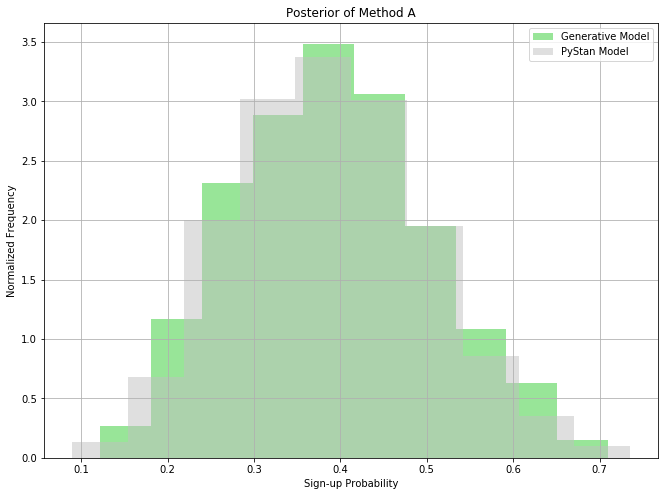

In [8]:
single_plot_format(title='Posterior of Method A', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=posterior_A,
                   df2=posterior_stanA['rate'],
                   alpha=.5,
                   color='limegreen',
                   color2='silver',
                   label='Generative Model',
                   label2='PyStan Model')

In [9]:
# Now you can summarize the posterior, where a common summary is to take the mean or the median posterior, 
# and perhaps a 95% quantile interval.
model_parameters=pd.DataFrame({
    'Posterior Median': [round(posterior_A.median(),2), round(posterior_stanA['rate'].median(),2)],
    'Posterior 95% quantile interval': [str(round(posterior_A.quantile(.025),2))+" - "+str(round(posterior_A.quantile(.975),2)),
                                        str(round(posterior_stanA['rate'].quantile(.025),2))+" - "+str(round(posterior_stanA['rate'].quantile(.975),2))]
}).T
model_parameters.columns = ['Generative Model', 'PyStan Model']
display(model_parameters)

,Generative Model,PyStan Model
Posterior Median,0.39,0.39
Posterior 95% quantile interval,0.19 - 0.61,0.19 - 0.61


## Question 2 - What’s the probability that method A is better than telemarketing?
So marketing just told us that the rate of sign-up would be 20% if salmon subscribers were snared by a telemarketing campaign instead (to us it’s very unclear where marketing got this very precise number from). So given the model and the data that we developed in the last question, what’s the probability that method A has a higher rate of sign-up than telemarketing?

---
### Results

In [10]:
print('The probability that Method A (using a generative model) is better than telemarketing is: %.3f' % (sum(posterior_A > .2) / len(posterior_A)))
print('The probability that Method A (using PyStan) is better than telemarketing is: %.3f' % (sum(posterior_stanA['rate'] > .2) / len(posterior_stanA['rate'])))

The probability that Method A (using a generative model) is better than telemarketing is: 0.965
The probability that Method A (using PyStan) is better than telemarketing is: 0.964


## Question 3 - If method A was used on 100 people what would be number of sign-ups?
Hint: The answer is again not a single number but a distribution over probable number of sign-ups.

---
### Results

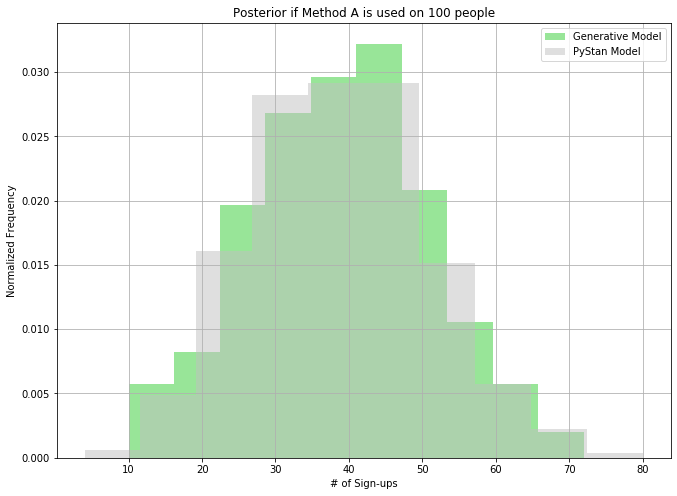

Sign-up 95% quantile interval (Generative Model): 16-62 sign-ups
Sign-up 95% quantile interval (PyStan Model): 17-63 sign-ups


In [11]:
signups_A = pd.Series([np.random.binomial(n=100, p=p) for p in posterior_A])
signups_stanA = pd.Series([np.random.binomial(n=100, p=p) for p in posterior_stanA['rate']])

single_plot_format(title='Posterior if Method A is used on 100 people', 
                   xlabel='# of Sign-ups', 
                   ylabel='Normalized Frequency',
                   df=signups_A,
                   df2=signups_stanA,
                   alpha=.5,
                   color='limegreen',
                   color2='silver',
                   label='Generative Model',
                   label2='PyStan Model')

print('Sign-up 95%% quantile interval (Generative Model): %d-%d sign-ups' % tuple(signups_A.quantile([.025,.975]).values))
print('Sign-up 95%% quantile interval (PyStan Model): %d-%d sign-ups' % tuple(signups_stanA.quantile([.025,.975]).values))


## Exercise 2: Bayesian A and B testing for Swedish Fish Incorporated
Method B involves sending out a similar brochure but including a free frozen salmon.
Marketing has tried out this method on 16 people and this time 10 signed up

---
### Using a generative model

In [12]:
# It was observed that 10 out of 16 people who recieved the mail signed up for the service.
observed_data_B = 10
                    
# Here you filter off all draws that do not match the data.
posterior_B = filter_w_observ(non_inform_prior, observed_data_B)

---
### Results

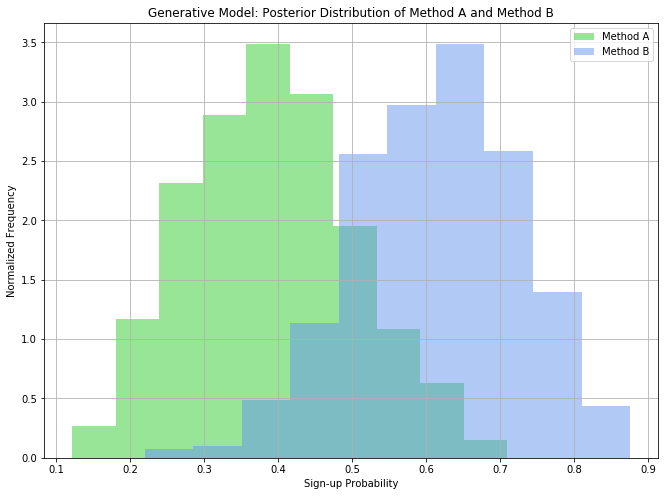

In [13]:
single_plot_format(title='Generative Model: Posterior Distribution of Method A and Method B', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=posterior_A,
                   df2=posterior_B,
                   alpha=.5,
                   color='limegreen',
                   color2='cornflowerblue',
                   label='Method A',
                   label2='Method B')

---
### Using PyStan

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_813b8efe37395e7f245d628f5687c1fe NOW.


Inference for Stan model: anon_model_813b8efe37395e7f245d628f5687c1fe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rate   0.61  2.9e-3   0.11   0.38   0.53   0.61   0.69   0.82   1486    1.0
lp__ -12.54    0.02   0.71 -14.68 -12.69 -12.26 -12.08 -12.03   2021    1.0

Samples were drawn using NUTS at Sun Jan 12 10:24:43 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)


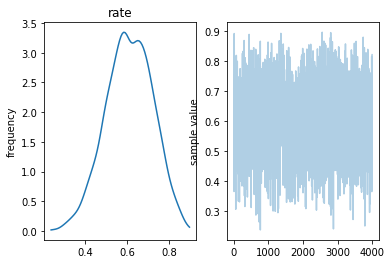

In [14]:
data_list_B = dict(n = 16, s = 10)

# Compiling and producing posterior samples from the model.
stan_samples_B = pystan.stan(model_code = model_string, data = data_list_B)

# Plotting and summarizing the posterior distribution
print(stan_samples_B)
print(stan_samples_B.plot())

# Export the samples to a data.frame for easier handling.
posterior_stanB = pd.DataFrame(stan_samples_B.extract())

---
### Results

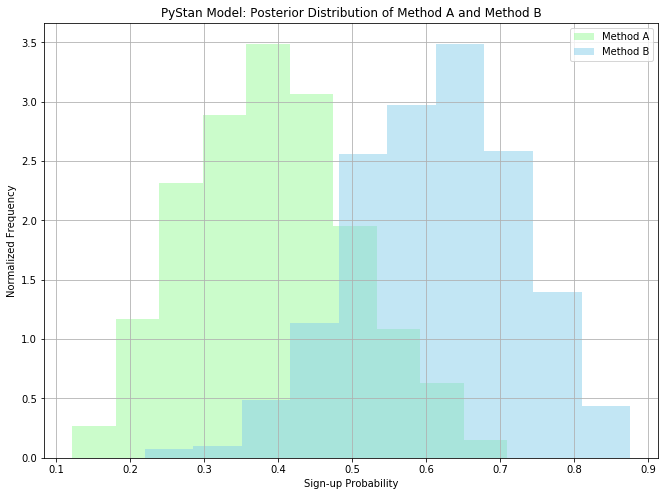

In [15]:
single_plot_format(title='PyStan Model: Posterior Distribution of Method A and Method B', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=posterior_A,
                   df2=posterior_B,
                   alpha=.5,
                   color='palegreen',
                   color2='skyblue',
                   label='Method A',
                   label2='Method B')

## Question 1 - What is the probability that Method B is better than Method A?

In [16]:
min_len = min(len(posterior_A), len(posterior_B))
post_df = pd.DataFrame({
    'Method A': list(posterior_A)[0:min_len],
    'Method B': list(posterior_B)[0:min_len]
})
post_df['Diff'] = post_df['Method B'] - post_df['Method A'] 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [17]:
post_df_stan = horizontal_stack = pd.concat([posterior_stanA['rate'], posterior_stanB['rate']], axis=1, keys=['rateA', 'rateB'])
post_df_stan['Diff (Stan)'] = post_df_stan['rateB'] - post_df_stan['rateA']

---
### Results

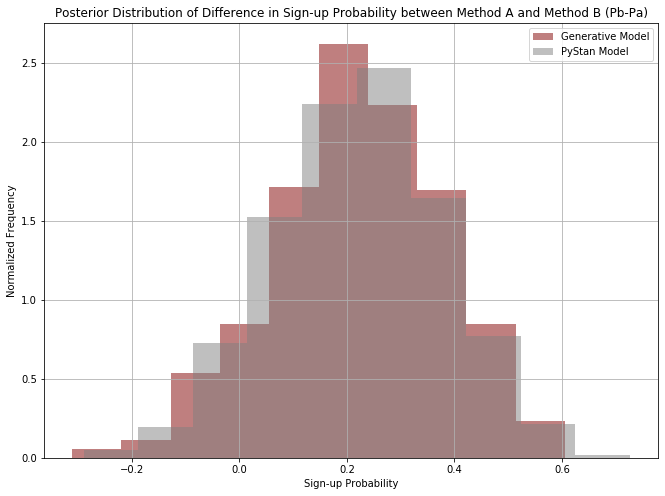

The probability (Generative Model) that Method B is better than Method A is: 0.910
The probability (PyStan Model) that Method B is better than Method A is: 0.918


In [18]:
single_plot_format(title='Posterior Distribution of Difference in Sign-up Probability between Method A and Method B (Pb-Pa)', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=post_df['Diff'],
                   df2=post_df_stan['Diff (Stan)'],
                   alpha=.5,
                   color='maroon',
                   color2='grey',
                   label='Generative Model',
                   label2='PyStan Model')
print('The probability (Generative Model) that Method B is better than Method A is: %.3f' % (sum(post_df['Diff'] > 0) / len(post_df['Diff'])))
print('The probability (PyStan Model) that Method B is better than Method A is: %.3f' % (sum(post_df_stan['Diff (Stan)'] > 0) / len(post_df_stan['Diff (Stan)'])))

## Question 2 - How can we include information sources in addition to the data? 
CEO says that the sign-up rate has never been higher than 20% and is usually between 5-15%  

In [19]:
from scipy.stats import beta

<Figure size 792x576 with 0 Axes>

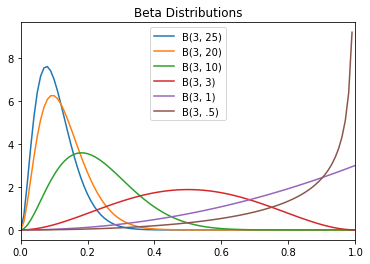

In [20]:
x = np.arange(0, 1.01, 0.01)
beta_df = pd.DataFrame({'B(3, 25)' : beta.pdf(x, 3, 25),
              'B(3, 20)' : beta.pdf(x, 3, 20),
              'B(3, 10)' : beta.pdf(x, 3, 10),
              'B(3, 3)' : beta.pdf(x, 3, 3),
              'B(3, 1)' : beta.pdf(x, 3, 1),
              'B(3, .5)' : beta.pdf(x, 3, .5)}, index = x)

plt.figure(figsize=(11,8))
ax = beta_df.plot()
plt.title('Beta Distributions')
plt.legend()
plt.show()   


In [21]:
a,b = 3,25
inform_prior = pd.Series(np.random.beta(3, 25, size = 10000),)

---
### Using a generative model

In [22]:
# Here you filter off all draws that do not match the data.
inform_posterior_A = filter_w_observ(inform_prior, observed_data_A)
inform_posterior_B = filter_w_observ(inform_prior, observed_data_B)

---
### Results

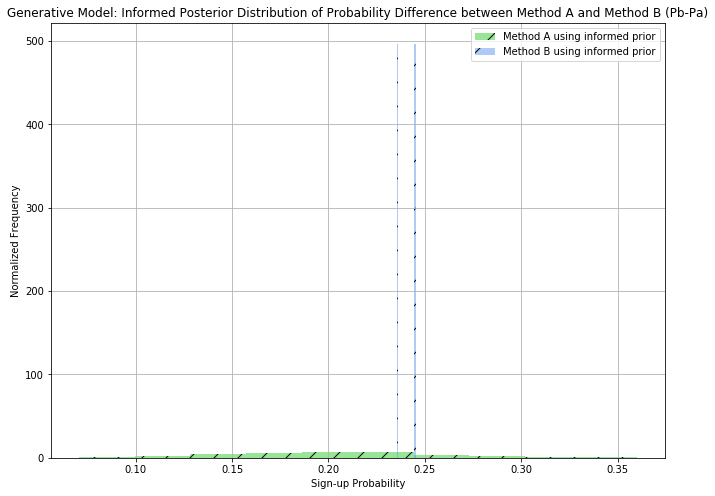

In [23]:
single_plot_format(title='Generative Model: Informed Posterior Distribution of Probability Difference between Method A and Method B (Pb-Pa)', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=inform_posterior_A,
                   df2=inform_posterior_B,
                   alpha=.5,
                   color='limegreen',
                   color2='cornflowerblue',
                   label='Method A using informed prior',
                   label2='Method B using informed prior',
                   hatch='/',
                   hatch2='/')

---
### Using PyStan

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ac27ec68f8d20d39adb9d18118907ef6 NOW.


Inference for Stan model: anon_model_ac27ec68f8d20d39adb9d18118907ef6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rateA       0.21  1.1e-3   0.06    0.1   0.16    0.2   0.25   0.34   3067    1.0
rateB       0.29  1.1e-3   0.07   0.17   0.25   0.29   0.34   0.44   3633    1.0
rate_diff   0.09  1.6e-3   0.09  -0.09   0.03   0.09   0.15   0.28   3496    1.0
lp__      -50.04    0.03   1.05  -52.9 -50.45  -49.7 -49.29 -49.03   1316    1.0

Samples were drawn using NUTS at Sun Jan 12 10:27:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Figure(432x288)


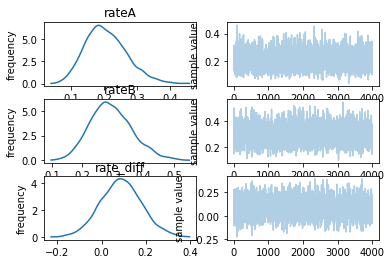

In [25]:
# The Stan model as a string.
model_string_informed = """
data {
  # Number of trials
  int nA;
  int nB;
  # Number of successes
  int sA;
  int sB;
}

parameters {
  real<lower=0, upper=1> rateA;
  real<lower=0, upper=1> rateB;
}

model {  
  rateA ~ beta(3, 25);
  rateB ~ beta(3, 25);
  sA ~ binomial(nA, rateA);
  sB ~ binomial(nB, rateB); 
}

generated quantities {
  real rate_diff;
  rate_diff <- rateB - rateA;
}
"""
data_lists_informed = dict(nA = 16, nB = 16, sA = 6, sB = 10)
# Compiling and producing posterior samples from the model.
stan_samples_informed = pystan.stan(model_code = model_string_informed, data = data_lists_informed)
print(stan_samples_informed)
print(stan_samples_informed.plot()) # The Stan model as a string.

In [26]:
inform_posterior_stan = pd.DataFrame(stan_samples_informed.extract())

---
### Results

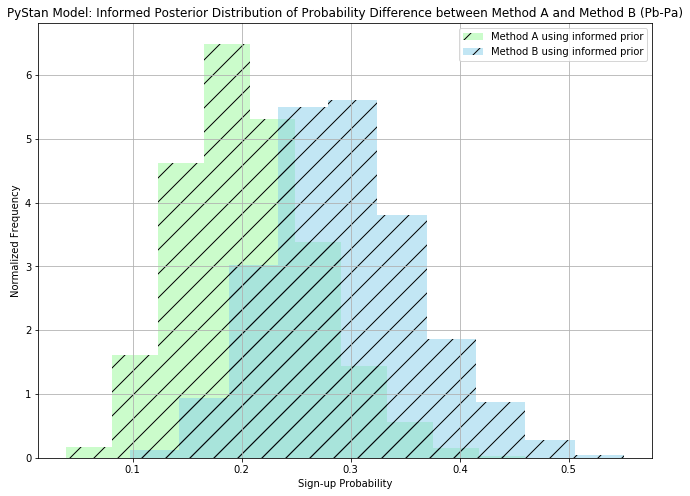

In [27]:
single_plot_format(title='PyStan Model: Informed Posterior Distribution of Probability Difference between Method A and Method B (Pb-Pa)', 
                   xlabel='Sign-up Probability', 
                   ylabel='Normalized Frequency',
                   df=inform_posterior_stan['rateA'],
                   df2=inform_posterior_stan['rateB'],
                   alpha=.5,
                   color='palegreen',
                   color2='skyblue',
                   label='Method A using informed prior',
                   label2='Method B using informed prior',
                   hatch='/',
                   hatch2='/')

#### The PyStan model seems to be a lot better than a generative model for an informed prior if the sample (e.g. Method B) has a posterior distribution median far away from the informed prior.

## Question 3 - CEO asks for a decision, which method is better? Includes this pricing information:
- cost of sending a brochure (method A) is 30 kr.
- cost of sending a salmon is 300 kr.
- if a person signs up, company makes 1000 kr on average.

The result of a Bayesian analysis retains the uncertainty of the estimated parameters, which is very useful in predictions and decision analysis.

In [28]:
post_df['Method A Profit'] = post_df['Method A'] * 1000 - 30
post_df['Method B Profit'] = post_df['Method B'] * 1000 - 300 - 30
post_df['Diff Profit'] = post_df['Method B Profit'] - post_df['Method A Profit']

In [29]:
post_df_stan['Method A Profit (stan)'] = post_df_stan['rateA'] * 1000 - 30
post_df_stan['Method B Profit (stan)'] = post_df_stan['rateB'] * 1000 - 300 - 30
post_df_stan['Diff Profit (stan)'] = post_df_stan['Method B Profit (stan)'] - post_df_stan['Method A Profit (stan)']

---
### Results

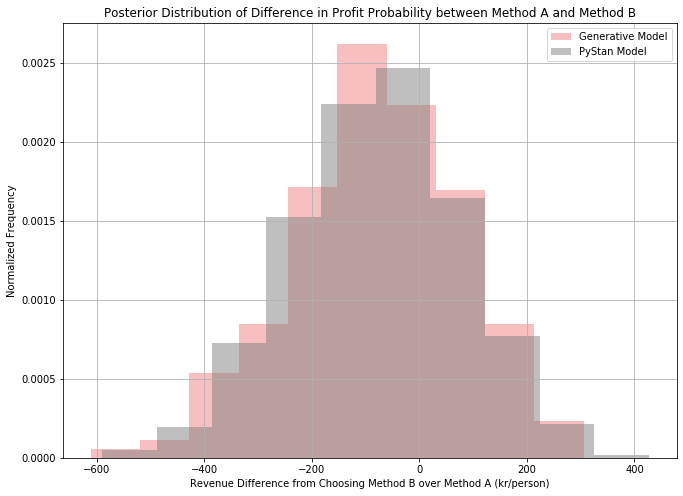

In [30]:
single_plot_format(title='Posterior Distribution of Difference in Profit Probability between Method A and Method B', 
                   xlabel='Revenue Difference from Choosing Method B over Method A (kr/person)', 
                   ylabel='Normalized Frequency',
                   df=post_df['Diff Profit'],
                   df2=post_df_stan['Diff Profit (stan)'],
                   alpha=.5,
                   color='lightcoral',
                   color2='grey',
                   label='Generative Model',
                   label2='PyStan Model')

In [31]:
model_parameters_profit = pd.DataFrame({
    'Average profit for Method A (kr/person)': [round((post_df['Method A Profit'].sum() / len (post_df['Method A Profit'])),0),
                                    round((post_df_stan['Method A Profit (stan)'].sum() / len(post_df_stan['Method A Profit (stan)'])),0)],
    'Average profit for Method B (kr/person)': [round((post_df['Method B Profit'].sum() / len (post_df['Method B Profit'])),0),
                                    round((post_df_stan['Method B Profit (stan)'].sum() / len(post_df_stan['Method B Profit (stan)'])),0)],
    'Probability that Method B will generate more Profits than Method A': [round(sum(post_df['Diff Profit'] > 0) / len(post_df['Diff Profit']),2),
                                                                           round(sum(post_df_stan['Diff Profit (stan)'] > 0) / len(post_df_stan['Diff Profit (stan)']),2)]
}).T
model_parameters_profit.columns = ['Generative Model', 'PyStan Model']
display(model_parameters_profit)

,Generative Model,PyStan Model
Average profit for Method A (kr/person),360.00,357.00
Average profit for Method B (kr/person),282.00,280.00
Probability that Method B will generate more Profits than Method A,0.31,0.31


## Question 4 - CEO asks for a decision, which method is better? Include pricing information and his past experience with sign-up rate as a CEO!

### Since using the informed posterior using the generative model has too little data we will only use the PyStan Model

In [33]:
inform_posterior_stan['Method A Profit (stan)'] = inform_posterior_stan['rateA'] * 1000 - 30
inform_posterior_stan['Method B Profit (stan)'] = inform_posterior_stan['rateB'] * 1000 - 300 - 30
inform_posterior_stan['Diff Profit (stan)'] = inform_posterior_stan['Method B Profit (stan)'] - inform_posterior_stan['Method A Profit (stan)']

---
### Results

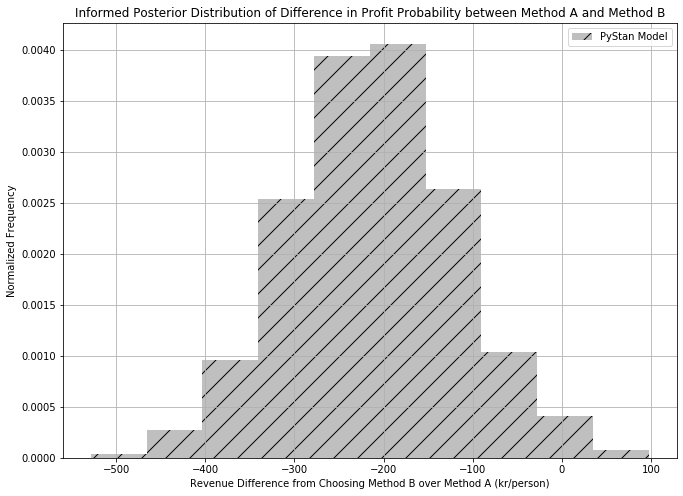

In [34]:
single_plot_format(title='Informed Posterior Distribution of Difference in Profit Probability between Method A and Method B', 
                   xlabel='Revenue Difference from Choosing Method B over Method A (kr/person)',
                   ylabel='Normalized Frequency',
                   df=inform_posterior_stan['Diff Profit (stan)'],
                   alpha=.5,
                   color='grey',
                   label='PyStan Model',
                   hatch='/')

In [35]:
informed_model_parameters_profit = pd.DataFrame({
    'Average profit for Method A (kr/person)': [round((inform_posterior_stan['Method A Profit (stan)'].sum() / len(inform_posterior_stan['Method A Profit (stan)'])),0)],
    'Average profit for Method B (kr/person)': [round((inform_posterior_stan['Method B Profit (stan)'].sum() / len(inform_posterior_stan['Method B Profit (stan)'])),0)],
    'Probability that Method B will generate more Profits than Method A': [round(sum(inform_posterior_stan['Diff Profit (stan)'] > 0) / len(inform_posterior_stan['Diff Profit (stan)']),2)]
}).T
informed_model_parameters_profit.columns = ['PyStan Model']
display(informed_model_parameters_profit)

,PyStan Model
Average profit for Method A (kr/person),176.00
Average profit for Method B (kr/person),-35.00
Probability that Method B will generate more Profits than Method A,0.01
